In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [ ]:
from torchvision import datasets, transforms
data_path = '/content/drive/MyDrive'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                  (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [ ]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [ ]:

conv = nn.Conv2d(3, 16, 3)

conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [ ]:
#conv weight size: out_feature * input*feature * kernel_size, in our case: 16*3*3*3
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [ ]:
# test the conv model, which expects input shape: B*C*H*W
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape, type(img)

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 30, 30]), torch.Tensor)

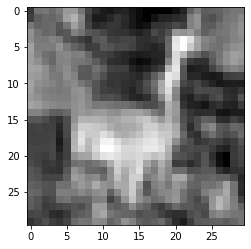

In [ ]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
# expecting to preserve the original size of pic, we will use padding
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
output.shape

torch.Size([1, 1, 32, 32])

## 检查weight矩阵的作用

In [ ]:
# bias=0, weight=1/9, 所以每一个像素将会是周围9格的平均
with torch.no_grad():
  conv.bias.zero_()

with torch.no_grad():
  conv.weight.fill_(1.0/9.0)

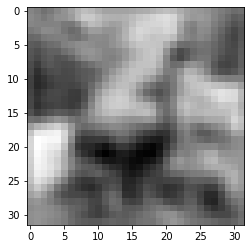

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
#每个图片的右列减去左列
conv = nn.Conv2d(3, 1, 3, 1)
with torch.no_grad():
  conv.weight[:] = torch.tensor([  [-1.0, 0.0, 1.0],
                     [-1.0, 0.0, 1.0],
                     [-1.0, 0.0, 1.0]
                                 ])
  conv.bias.zero_()

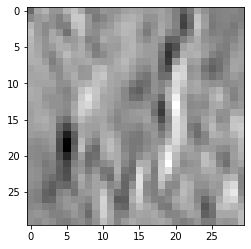

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

## from large picture to small: downsampling, maxpooling

In [ ]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

## put it all together

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, 1),#input, output, kernelsize, padding
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, 3, 1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # turn 8 channel 8*8 picture into 1D vector to produce prob
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [ ]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list 

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
model(img.unsqueeze(0))

RuntimeError: ignored

# make our submodule

In [ ]:
# switch to functional API to avoid store non-parameter function in our model
# that is why we abandon nn.Tanh(), nn.MaxPool2d and turn to torch.tanh(), F.maxpool()
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, padding=2)
    #self.act1 = nn.Tanh()
    #self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8 ,kernel_size = 5, padding=2)
    #self.act2 = nn.Tanh()
    #self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8*8*8, 32)
    #self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    out = F.max_pool2d( torch.tanh( self.conv1(x) ), 2)
    out = F.max_pool2d( torch.tanh( self.conv2(out) ), 2 )
    out = out.view(-1, 8*8*8) # most important line! to tackcle the former warning
    out = torch.tanh( self.fc1(out) )
    out = self.fc2(out)
    return out


In [ ]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

In [ ]:
model = Net()
model(img.unsqueeze(0))

## time to train our own model

In [ ]:
import datetime

def trainning_loop(n_epoches, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, 1+n_epoches):
    loss_train =0.0
    for imgs, labels in train_loader:
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()  #use item() function to transfrom it to a Python number
    if epoch==1 or epoch % 10==0:
      print('{} Epoch {}, Trainning loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle = True)
model = Net()
optimizer = optim.SGD(model.parameters(), 1e-2)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
trainning_loop(100, optimizer, model, loss_fn, train_loader)

In [ ]:


def validate(model, train_loader, val_loader):
  for name, loader in [('train', train_loader), ('val', val_loader)]:
    correct, total = 0, 0

    with torch.no_grad():
      for imgs, labels in loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int( (labels == predicted).sum() )
      
    print('Accuracy {}: {:.2f} '.format(name, correct/total))


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = False)

In [ ]:
validate(model, train_loader, val_loader)
# kernel size = 3, 0.93 on train, 0.88 on val
# kernel size = 5, 0.97 on train, 0.88 on val

## store and load the parameters

In [ ]:
torch.save(model.state_dict(), data_path+'/birds_vs_airplanes.pt')


In [ ]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/birds_vs_airplanes.pt'))

# using GPU

In [ ]:
#checke whether the GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"training on device {device}")

training on device cuda


In [ ]:
# switch to functional API to avoid store non-parameter function in our model
# that is why we abandon nn.Tanh(), nn.MaxPool2d and turn to torch.tanh(), F.maxpool()
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, padding=2)
    #self.act1 = nn.Tanh()
    #self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8 ,kernel_size = 5, padding=2)
    #self.act2 = nn.Tanh()
    #self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8*8*8, 32)
    #self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    out = F.max_pool2d( torch.tanh( self.conv1(x) ), 2)
    out = F.max_pool2d( torch.tanh( self.conv2(out) ), 2 )
    out = out.view(-1, 8*8*8) # most important line! to tackcle the former warning
    out = torch.tanh( self.fc1(out) )
    out = self.fc2(out)
    return out


In [ ]:
#we mainly use .to() function, the GPU can help us to increase training speed
def training_loop_gpu(n_epoches, optimizer, loss_fn, train_loader):
  for epoch in range(1, 1+ n_epoches):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device = device)
      labels = labels.to(device = device) #these 2 lines are major different

      outputs = model(imgs)
      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss
    if epoch==1 or epoch%10==0:
      print('{} Epoch {}, Loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)
model = Net().to(device = device) # remember to transfer the Net to GPU as well!
optimizer = optim.SGD(model.parameters(), lr=1e-2) 
loss_fn = nn.CrossEntropyLoss()


In [ ]:
import datetime
training_loop_gpu(100, optimizer, loss_fn, train_loader)

2021-02-10 14:57:49.310864 Epoch 1, Loss 0.47730693221092224
2021-02-10 14:57:52.600787 Epoch 10, Loss 0.31472137570381165
2021-02-10 14:57:56.293862 Epoch 20, Loss 0.275509774684906
2021-02-10 14:57:59.980038 Epoch 30, Loss 0.24683944880962372
2021-02-10 14:58:03.673513 Epoch 40, Loss 0.21980898082256317
2021-02-10 14:58:07.288320 Epoch 50, Loss 0.19890835881233215
2021-02-10 14:58:11.122820 Epoch 60, Loss 0.17566034197807312
2021-02-10 14:58:14.878909 Epoch 70, Loss 0.15419557690620422
2021-02-10 14:58:18.664368 Epoch 80, Loss 0.13913945853710175
2021-02-10 14:58:22.329181 Epoch 90, Loss 0.12175217270851135
2021-02-10 14:58:25.967274 Epoch 100, Loss 0.10535082221031189


In [ ]:
def validate_gpu(model, train_loader, val_loader):
  for name, loader in [('train', train_loader), ('val', val_loader)]:
    correct, total = 0, 0

    with torch.no_grad():
      for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int( (labels == predicted).sum() )
      
    print('Accuracy {}: {:.2f} '.format(name, correct/total))


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = False)
validate_gpu(model, train_loader, val_loader)

Accuracy train: 0.97 
Accuracy val: 0.88 


# Chapter8-exe

In [ ]:
import cv2
image = cv2.imread('/content/drive/MyDrive/deep_learning_with_pytorch/rosket.jpg')

In [ ]:
image.shape, type(image)

((341, 500, 3), numpy.ndarray)

In [ ]:
img = cv2.resize(image, (32, 32), interpolation=cv2.INTER_CUBIC)

In [ ]:
img.shape

(32, 32, 3)

In [ ]:
img = torch.from_numpy(img).permute(2, 0, 1)

In [ ]:
img.shape, type(img)

(torch.Size([3, 32, 32]), torch.Tensor)

In [ ]:
m = model.to(device)
out = m(img.unsqueeze(0).float().to(device))

In [ ]:
out

tensor([[-4.3955,  3.8835]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
# when store data, pytorch will store where the data derive, so we need to override the device info when loading
loaded_model = Net().to(device=device)

loaded_model.load_state_dict(torch.load("/content/drive/MyDrive/birds_vs_airplanes.pt", map_location = device))

<All keys matched successfully>

# model design

## regularization

In [ ]:
def train_loop_gpu_reg(n_epoches, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, 1+n_epoches):
    train_loss = 0.0
    for imgs, labels in train_loader:
      imgs, labels = imgs.to(device), labels.to(device)

      outputs = model(imgs)
      loss = loss_fn(outputs, imgs)

      l2_lambda = 1e-3
      l2_norm = sum(p.pow(2.0).sum() for p in model.parameters() )
      loss += l2_norm

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += float(loss)
    if epoch == 1 or epoch%10==0:
      print('{} Epoch {}, Loss {}'.format(datetime.datetime.now(), epoch, train_loss/len(train_loader)))

## dropout

In [ ]:
# dropout strategy, applying nn.dropout in out model
import torch.nn as nn
class NetDropOut(nn.Module):
  def __init__(self, n_chansl = 32):
    super().__init__()
    self.n_chansl = n_chansl
    self.conv1 = nn.Conv2d(3, n_chansl, 3, padding = 1)
    self.drop1 = nn.Dropout2d(p=0.4)
    self.conv2 = nn.Conv2d(n_chansl, n_chansl//2, 3, padding = 1)
    self.drop2 = nn.Dropout2d(p=0.4)
    self.fc1  = nn.Linear(8*8*n_chansl//2, 32)
    self.fc2  = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d( torch.tanh( self.conv1(x) ), 2 )
    out = self.drop1(out)
    out = F.max_pool2d( torch.tanh( self.conv2(out)), 2 )
    out = self.drop2(out)

    out = out.view(-1, 8*8*self.n_chansl)

    out = torch.tanh(self.fc1(out) )
    out = self.fc2(out)
    return out

## batch normalization

In [ ]:
# batch normalization, nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d
# 首先在__init__中要实现bn函数，其次在前向传播时，应在进入tanh之前运用bn
class NetBN(nn.Module):
  def __init__(self, n_chansl = 32):
    super().__init__()
    self.n_chansl = n_chansl
    self.conv1 = nn.Conv2d(3, n_chansl, 3, padding = 1)
    self.bn1 = nn.BatchNorm2d(n_chansl)
    self.conv2 = nn.Conv2d(n_chansl, n_chansl//2, 3, padding = 1)
    self.bn2 = nn.BatchNorm2d(n_chansl//2)
    self.fc1  = nn.Linear(8*8*n_chansl//2, 32)
    self.fc2  = nn.Linear(32, 2)

  def forward(self, x):
    out = self.bn1( self.conv1(x) )
    out = F.max_pool2d(torch.tanh(out), 2)
    out = self.bn2( self.conv2(out))
    out = F.max_pool2d( torch.tanh(out), 2 )

    out = out.view(-1, 8*8*self.n_chansl)

    out = torch.tanh(self.fc1(out) )
    out = self.fc2(out)
    return out

## res network

In [ ]:
# residual network, aidding to build a very deep model
# change the activation function to nn.relu(), add another conv layer
class NetDepth(nn.Module):
  def __init__(self, n_chansl = 32):
    super().__init__()
    self.n_chansl = n_chansl
    self.conv1 = nn.Conv2d(3, n_chansl, 3, padding = 1)
    
    self.conv2 = nn.Conv2d(n_chansl, n_chansl//2, 3, padding = 1)
    self.conv3 = nn.Conv2d(n_chansl//2, n_chansl//2, 3, padding = 1)
    self.fc1  = nn.Linear(4*4*n_chansl//2, 32)
    self.fc2  = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d( torch.relu( self.conv1(x) ), 2 )
    
    out = F.max_pool2d( torch.relu( self.conv2(out)), 2 )
    out = F.max_pool2d( torch.relu( self.conv3(out)), 2 )

    out = out.view(-1, 4*4*self.n_chansl)

    out = torch.relu(self.fc1(out) )
    out = self.fc2(out)
    return out

In [ ]:
import torch.nn as nn
class NetRes(nn.Module):
  def __init__(self, n_chansl = 32):
    super().__init__()
    self.n_chansl = n_chansl
    self.conv1 = nn.Conv2d(3, n_chansl, 3, padding = 1)
    
    self.conv2 = nn.Conv2d(n_chansl, n_chansl//2, 3, padding = 1)
    self.conv3 = nn.Conv2d(n_chansl//2, n_chansl//2, 3, padding = 1)
    self.fc1  = nn.Linear(4*4*n_chansl//2, 32)
    self.fc2  = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d( torch.relu( self.conv1(x) ), 2 )
    out = F.max_pool2d( torch.relu( self.conv2(out)), 2 )

    out1 = out

    out = F.max_pool2d( torch.relu( self.conv3(out)) + out1, 2 )
    out = out.view(-1, 4*4*self.n_chansl)
    out = torch.relu(self.fc1(out) )
    out = self.fc2(out)
    return out

## build a very deep NES network


In [ ]:
# it consists of 100 ResBolocks and other parts
# 1 write a subclass: ResBlock
class ResBlock(nn.Module):
  def __init__(self, n_chans):
    super().__init__()
    self.n_chans = n_chans
    self.conv = nn.Cov2d(n_chans, n_chans, 3, padding=1, bias=False)
    self.bn  = nn.BatchNorm2d(num_features = n_chans)
    
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity = 'relu') #initialize bn's paras according to some paper

    torch.nn.init.constant_(self.bn.weight, 0.5)

    torch.nn.init.zeros_(self.bn.bias)
  
  def forward(self, x):
    out = self.conv(x)
    out = self.bn(out)
    out = torch.relu(out)
    return out+x

In [ ]:
# 2 build the whole network
class NetResDeep(nn.Module):
  def __init__(self, n_chans1=32, n_blocks = 10):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, 3, padding = 1)
    self.resblocks = nn.Sequential(
        *(n_blocks * [ResBlock(n_chans = n_chans1)])
    )
    self.fc1 = nn.Linear(8*8*n_chans1, 32)
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    out = F.max_pool2d( torch.tanh( self.conv1(x)), 2 )
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 8*8*self.n_chans1)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out